# Time Series Analysis

Below we perform a series of statistical analysis in order to have a better understanding of the features.

In [1]:
%matplotlib notebook
# %load_ext autoreload
# %autoreload 0

# built in
import datetime as dt
import os
import pathlib
import sys

from functools import partial
from importlib import reload

# third party
import ipywidgets as widgets
import matplotlib as mpl
import numpy as np
import pandas as pd

from IPython.display import display

# internal
if sys.platform == 'win32':
    scripts_path = pathlib.Path(os.getcwd()).parents[0]
    if not str(scripts_path) in sys.path:
        sys.path.append(str(scripts_path))

import formatting
import jeffapi
import mywidgets
import plotting
import rtsa
import tsa


In [2]:
# reloading
reload(formatting)
reload(jeffapi)
reload(mywidgets)
reload(plotting)
reload(tsa)
reload(rtsa);

In [3]:
w1 = mywidgets.asset_dropdown
display(w1)

Dropdown(options=(('ADP CHNG Index ECO_RELEASE_DT', 'd5d866da-d247-46fd-9f22-050abeb43a83'), ('AICIPCI Index E…

In [4]:
s = jeffapi.get_timeseries(w1.value)

In [5]:
print(f'The series has an inferred frequency of {tsa.infer_freq(s)}')
display(formatting.days_count_format(tsa.time_delta_count(s)))
display(formatting.days_count_format(tsa.day_count(s)))
s_na = s[s.isna()]
print(f'{s_na.shape[0]} NaN found in the series out of {s.shape[0]}')

The series has an inferred frequency of <MonthEnd>


0 NaN found in the series out of 162


### 2. Transformation
In the drop down menu below you can select the transformation to apply to the original series, as well as the time interval.
The parameters ***diff*** and ***lambda*** are respectively used for the order of differencing and for the box-cox trasformation which is:
\begin{equation}
    y=
    \begin{cases}
      \frac{x ^ {\lambda} -1 }{\lambda}, & \text{if}\ \lambda \neq 0 \\
      log(x), & \text{otherwise}
    \end{cases}
  \end{equation}
where ***lambda*** is between 0 and 1.

In [6]:
w2 = widgets.interactive(tsa.transform, x=widgets.fixed(s.dropna()), date_range=mywidgets.date_range_slider(s.dropna()), 
                        d=mywidgets.diff_slider, l=mywidgets.lambda_slider, method=mywidgets.transform_dropdown);
display(w2)

interactive(children=(SelectionRangeSlider(description='date_range', index=(0, 161), layout=Layout(width='50%'…

### 3. Time series analysis
Below we show a table with summary statistics, the ACF and PACF plot as well as the kenrel density estimation of the time series. ACF and PACF are useful in assessing the if the staionarity conditions are met.

In [7]:
x = w2.result
display(formatting.summary(x))
# plotting.ts_plot(x);
w3 = widgets.interactive(plotting.ts_plot, x=widgets.fixed(x), window=mywidgets.moving_slider, acf_lags=widgets.fixed(None));
display(w3)

interactive(children=(IntSlider(value=20, description='window', max=520, min=1), Output()), _dom_classes=('wid…

### 4.Stationarity test
Below we show a summary with the the most known tests for stationarity.
As a rule of thumb, if one among ***adf***, ***pp*** or ***dfgls*** agrees with ***kpss*** we can be confident that the time series show some form of stationarity

In [8]:
formatting.stationarity_format(x)

### 5. Auto Arima
The auto arima algorithm returns the best ARIMA model according to either AIC, AICc or BIC value. This function conducts a search over a range of possible models within the constraints provided. This can provide a first information regarding the order of differencing and seasonal differencing needed for stationarizing the series. 
Since it uses R auto.arima under the wood, in order to detect potential seasonality, it would be better to specify the the frequency of data from the DropDown below.


In [9]:
w4 = mywidgets.frequency_dropdown
display(w4)

Dropdown(description='frequency', options=(('None', 1), ('Monthly', 12), ('Weekly', 7), ('Yearly', 365.25)), v…

In [21]:
mdl = rtsa.AutoARIMA(x, ts_kwargs={'frequency': w4.value}).fit();
print(f'The model selected by Auto Arima is: {mdl.mdl_name}')

The model selected by Auto Arima is: ARIMA(0,1,0)


### 6. Outliers detection
The outlier detection in univariate time series has been performed according to seven different methods.
The tab below allows to specify the threshold for each method, which determines the number of observations flagged as outliers.

In [22]:
tab = mywidgets.outliers_args_tab()
display(tab)

<IPython.core.display.Javascript object>


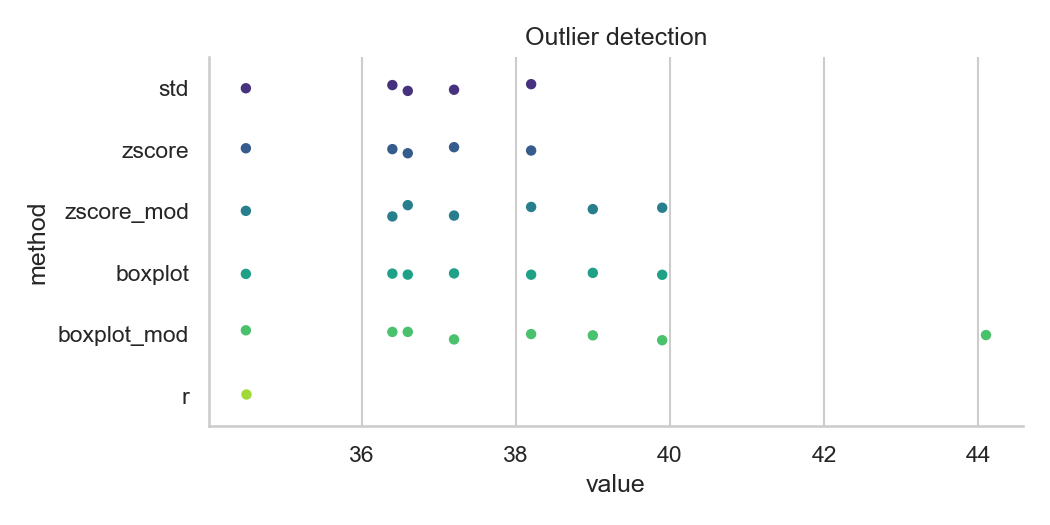

In [24]:
plotting.outliers_all_plot(x, mywidgets.tab_out(tab));

In [25]:
widgets.interact(plotting.outliers_plot, x=widgets.fixed(x), d=widgets.fixed(mywidgets.tab_out(tab)), 
                 method=mywidgets.outliers_dropdown);

interactive(children=(Dropdown(description='method', options=(('outliers_median_rule', <function outliers_medi…

### 7. Seasonality
The drop down menu below gives the possibility to select a different method to detect seasonality in the time series. <br>
The seasonal models implemented are the following:
1. **X13ARIMA** 
2. **STL** (https://otexts.com/fpp2/stl.html)
3. **ETS** (https://otexts.com/fpp2/expsmooth.html)
4. **TBATS** (https://otexts.com/fpp2/complexseasonality.html#tbats-models)
The last three model are implemented in python using the rpy2 package and are often used as a benchmark against other forecasting models, including Neural Networks
**X13ARIMA** only work with monthly data.
For details see Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2.

In [26]:
w4 = mywidgets.frequency_dropdown
display(w4)
print(f'The automatic seasonality decetion suggests a seasolnality equal to: {rtsa.findfrequency(x)}')

Dropdown(description='frequency', index=1, options=(('None', 1), ('Monthly', 12), ('Weekly', 7), ('Yearly', 36…

The automatic seasonality decetion suggests a seasolnality equal to: [1]


In [114]:
w5 = widgets.interactive(tsa.seasonal_models_fit, x=widgets.fixed(x), model=mywidgets.seasonal_dropdown, 
                    ts_kwargs=widgets.fixed({'frequency': w4.value}));
display(w5)

interactive(children=(Dropdown(description='model', options=(('X13ARIMA', <class 'tsa.X13ARIMA'>), ('ETS', <cl…

<IPython.core.display.Javascript object>


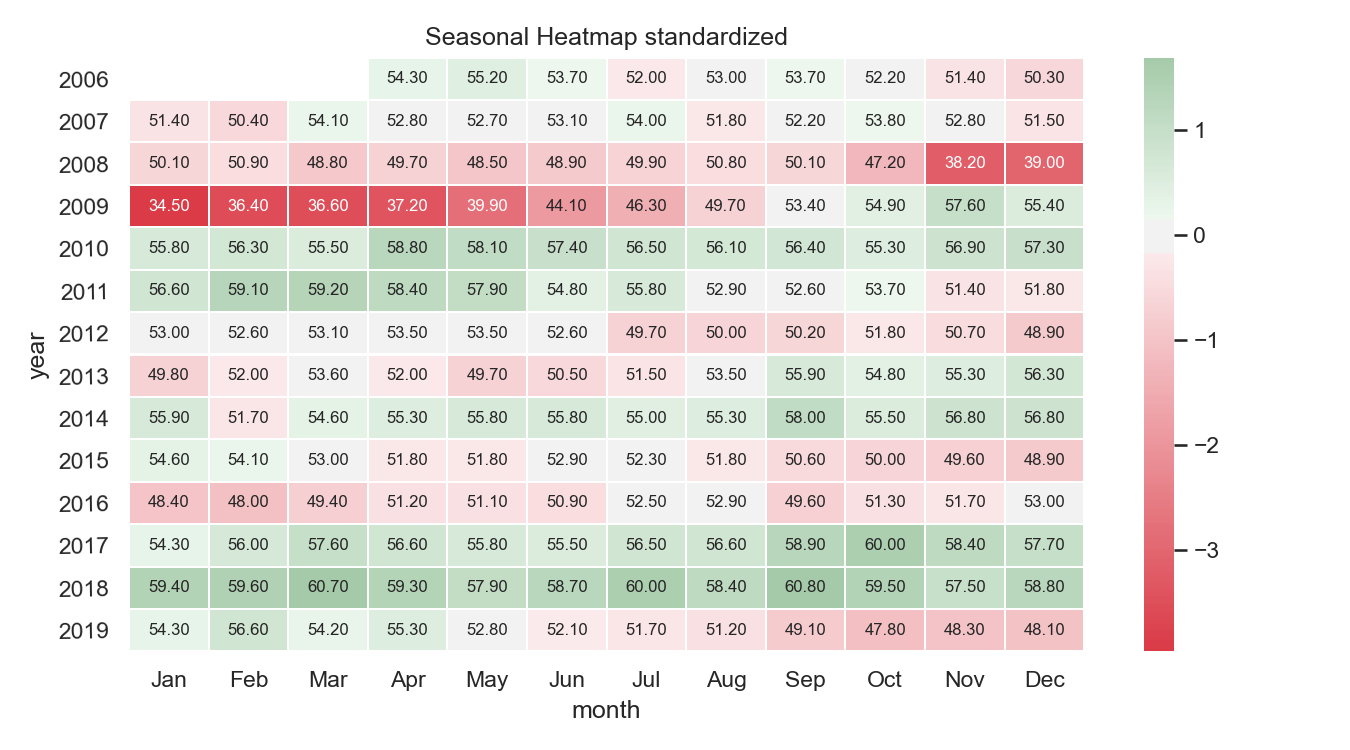

In [85]:
plotting.heat_plot(x, resample='M', fun='sum', index='year', columns='month', scale=True);

### 8.Fractional Difference
The widget below gives two options for checking the degree of fractional difference:
1. Auto check performs a search over the interval [0, 1] and stops when it finds a degree of defferencing that satisfies **DFGLS** and **KPSS** tests for stationarity.
2. If the Auto check box is unchecked, a specific value for the degree of differencig can be selected using the slider. 


In [111]:
w6 = widgets.interactive(plotting.fractional_plot, x=widgets.fixed(x), check=mywidgets.frac_diff_auto_checkbox,
                         d=mywidgets.frac_diff_slider, fd_kwargs=widgets.fixed(None), cfd_kwargs=widgets.fixed(None))
display(w6)

interactive(children=(FloatSlider(value=0.5, description='degree', max=1.0, step=0.01), Checkbox(value=False, …